In [59]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 2.4/212.5 MB 12.2 MB/s eta 0:00:18
    --------------------------------------- 4.2/212.5 MB 10.5 MB/s eta 0:00:20
   - -------------------------------------- 6.8/212.5 MB 11.3 MB/s eta 0:00:19
   - -------------------------------------- 10.5/212.5 MB 13.1 MB/s eta 0:00:16
   -- ------------------------------------- 14.2/212.5 MB 14.1 MB/s eta 0:00:15
   --- ------------------------------------ 17.8/212.5 MB 14.8 MB/s eta 0:00:14
   --- ------------------------------------ 21.0/212.5 MB 14.7 MB/s eta 0:00:14
   ---- ----------------------------------- 24.1/212.5 MB 14.8 MB/s eta 0:00:13
   ----- ---------------------------------- 28.0/212.5 MB 15.3 MB/s eta 0:00:13
   ----- ---------------------------------- 31.7/212.5 MB 15.6 MB/s eta 0:00:12
   ------ --------------------------------- 35.7/212.5 MB 1


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: C:\Users\nagas\Documents\673_new\new_env\Scripts\python.exe -m pip install --upgrade pip


In [29]:
import numpy as np

from tensorflow.keras.utils import Sequence

import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math
import random

# define the size for the images to be resized to
img_size = (256, 256)
# define the batch size for the training
batch_size = 10
learning_rate = 1e-4

# The directory holding all of the subdirectories with the dataset
# TODO: set the appropriate path to the images directory

dataset_directory_train = './trainset1/'
dataset_directory_val = './validationset1/'
dataset_directory_test = './testset/'

# The directory to save the model weights
weights_save_location = 'C:/Users/nagas/Documents/673_new/weights/'

In [31]:
def categorical_encoding_to_prob(img, num_of_classes):
    res_img = np.zeros((img.shape[0], img.shape[1], num_of_classes))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if len(img.shape) == 2:
                index = img[i][j]
            else:
                index = img[i][j][0]
            res_img[i][j][index] = 1

    return res_img

In [33]:
def rgb_to_categorical(img, colors):
    res_img = np.zeros((img.shape[0],img.shape[1]), dtype=int)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tuple(img[i][j]) in colors:
                res_img[i][j] = colors.index(tuple(img[i][j]))
            else:
                res_img[i][j] = 0
    
    return res_img

In [35]:
class DirectoryFlow(Sequence):
    """ Class used to read images from directory in chunks.
    
    This one should allow us to read all of the images from the directories in 
    chunks. Provided directories are ones where original images and their
    corresponding labels reside.  
    For now no augmentations are applied to the elements.
    """
    def __init__(self, x_dir_path, y_dir_path, batch_size, img_size, img_ext='.jpg', label_suffix_ext='_lab.png', skip_encoding=False, is_rgb=False, colors=None):
        """ Creates a list of filenames for latter use. 
        
        Since some of the pictures or maps might have no counterparts in the 
        other directory we should leave only those that do in the list.
        The list contains names  without suffixes and extensions
        """
        self.x_dir_path = x_dir_path
        self.y_dir_path = y_dir_path

        x_list = os.listdir(x_dir_path)
        y_list = os.listdir(y_dir_path)

        self.data_names_list = [x_el.split('.')[0] for x_el in x_list if x_el.split('.')[0]+label_suffix_ext]
        self.temp_data_names = self.data_names_list.copy()
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_ext = img_ext
        self.label_suffix_ext = label_suffix_ext
        self.skip_encoding = skip_encoding
        self.is_rgb = is_rgb
        self.colors = colors

    def _get_image_batch(self, allow_duplicates=False):
        """ Polls temp_data_names for random elements, returns corresponding images.

        Elements are polled using np.random.choice() and are removed on use.
        Then, images and their respective masks are read with a help of the cv2.imread
        and the colors are changed properly from BGR to RGB.
        After that we resize the image and normalize it before feeding into the network

        returns: list of image arrays
        """
        images = []
        labels = []
        if allow_duplicates:
            image_names_list = np.random.choice(self.temp_data_names, (self.batch_size))
        else:
            image_names_list = random.sample(self.temp_data_names, (self.batch_size))
            
        self.temp_data_names = [x for x in self.temp_data_names if x not in image_names_list]

        for i_name in image_names_list:
            image = cv2.imread(self.x_dir_path + '/' + i_name + self.img_ext)
            image = cv2.resize(image, self.img_size, interpolation=cv2.INTER_NEAREST)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image*(1./255)
            
            label = cv2.imread(self.y_dir_path + '/' + i_name + self.label_suffix_ext)
            label = cv2.resize(label, self.img_size, interpolation=cv2.INTER_NEAREST)
            if not self.skip_encoding:
                if self.is_rgb:
                    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
                    label = rgb_to_categorical(label, colors)
                label = categorical_encoding_to_prob(label, 11)
            else:
                label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

            images.append(image)
            labels.append(label)

        return (np.array(images), np.array(labels))

    def __len__(self):
        return int(math.floor(len(self.data_names_list)/self.batch_size))


    def __getitem__(self, index):
        """We discard the index as we are polling random samples"""
        return self._get_image_batch()

    def reset_temp_data_names(self):
        """ Fills temp_data_names with the original list stored in the data_names_list.
        
        Might be used as a callback in order to reset the list between different epochs.
        """
        self.temp_data_names = self.data_names_list.copy()
  
    def on_epoch_end(self):
      self.reset_temp_data_names()

In [37]:
class AugDirectoryFlow(DirectoryFlow):
    """ Class used to read images from directory in chunks.
    
    This one should allow us to read any amount of the images from the 
    directories in chunks. Provided directories are ones where original 
    images and their corresponding labels reside.  
    Augmentations available are horizontal and vertical flip, rotation and zoom in.
    Note that rotation is integer that represents degrees and zoom in is float and
    the value provided is not included in the range
    """
    def __init__(self, x_dir_path, y_dir_path, batch_size, img_size, img_ext='.jpg', label_suffix_ext='_lab.png',\
                 h_flip=False, v_flip=False, rotation_deg=0, zoom_in_scale=1.0, skip_encoding=False, is_rgb=False, colors=None):
        """ Creates a list of filenames for latter use. 
        
        Since some of the pictures or maps might have no counterparts in the 
        other directory we should leave only those that do in the list.
        The list contains names  without suffixes and extensions
        """
        super().__init__(x_dir_path, y_dir_path, batch_size, img_size, img_ext, label_suffix_ext, skip_encoding, is_rgb, colors)
        self.h_flip = h_flip
        self.v_flip = v_flip
        self.rotation_deg = rotation_deg
        if(zoom_in_scale<1.0):
            raise ValueError('Zoom_in_scale is expected to be 1.0 or higher')
            zoom_in_scale = 1.0
        self.zoom_in_scale = zoom_in_scale

    def _apply_augmentations(self,data_pairs):
        images, labels = data_pairs
        for i in range(len(images)):
            if(self.v_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],0)
                    labels[i] = cv2.flip(labels[i],0)
            if(self.h_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],1)
                    labels[i] = cv2.flip(labels[i],1)
            if(self.rotation_deg > 0 or self.zoom_in_scale > 1.0):
                degrees = 0
                if(self.rotation_deg > degrees):
                    degrees = np.random.randint(0,self.rotation_deg+1)
                
                scale = 1.0
                if(self.zoom_in_scale > scale):
                    scale = np.random.uniform(1.0,self.zoom_in_scale)
                    
                height, width, _ = images[i].shape
                rotation = cv2.getRotationMatrix2D((height/2, width/2),\
                                                   degrees,scale)
                images[i] = cv2.warpAffine(images[i], rotation, (width, height))
                labels[i] = cv2.warpAffine(labels[i], rotation, (width, height))
        return (images, labels)
            
        
    def __getitem__(self, index):
        """We discard the index as we are polling random samples"""
        data_pairs = super()._get_image_batch()
        data_pairs = self._apply_augmentations(data_pairs)
        self.reset_temp_data_names()
        return data_pairs

    def reset_temp_data_names(self):
        """ Fills temp_data_names with the original list stored in the data_names_list.
        
        Might be used as a callback in order to reset the list between different epochs.
        """
        super().reset_temp_data_names()

    def on_epoch_end(self):
        pass

In [39]:
dataset_classes_names = {'unlabelled':0, 'water':1, 'building-no-damage':2,\
                         'building-medium-damage':3, 'building-major-damage':4,\
                         'building-total-destruction':5,\
                         'vehicle':6, 'road-clear':7, 'road-blocked':8,\
                         'tree':9, 'pool':10}

colors = [(0, 0, 0),         # Background - Black
    (0, 0, 255),       # Water - Blue
    (0, 255, 0),       # Building No Damage - Green
    (255, 255, 0),     # Building Minor Damage - Yellow
    (255, 165, 0),     # Building Major Damage - Orange
    (255, 0, 0),       # Building Total Destruction - Red
    (0, 255, 255),     # Vehicle - Cyan
    (255, 255, 255),   # Road-Clear - White
    (128, 128, 128),   # Road-Blocked - Gray
    (34, 139, 34),     # Tree - Forest Green
    (75, 0, 130)       # Pool - Indigo
         ]

In [41]:
def class_code_to_rgb(image):
    image = image.numpy()
    result_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            px_class = image[i][j]
            result_img[i][j][0] = px_class*20
            result_img[i][j][1] = px_class*20
            result_img[i][j][2] = px_class*20
    return result_img

In [43]:
def class_code_to_rgb_w_colors(image, colors, use_np=False):
    if not use_np:
        image = image.numpy()
    result_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            px_class = image[i][j]
            result_img[i][j][0] = colors[px_class][0]
            result_img[i][j][1] = colors[px_class][1]
            result_img[i][j][2] = colors[px_class][2]
    return result_img

In [45]:
class AugDirectoryFlow(DirectoryFlow):
    """ Class used to read images from directory in chunks.
    
    This one should allow us to read any amount of the images from the 
    directories in chunks. Provided directories are ones where original 
    images and their corresponding labels reside.  
    Augmentations available are horizontal and vertical flip, rotation and zoom in.
    Note that rotation is integer that represents degrees and zoom in is float and
    the value provided is not included in the range
    """
    def __init__(self, x_dir_path, y_dir_path, batch_size, img_size, img_ext='.jpg', label_suffix_ext='_lab.png',\
                 h_flip=False, v_flip=False, rotation_deg=0, zoom_in_scale=1.0, skip_encoding=False, is_rgb=False, colors=None):
        """ Creates a list of filenames for latter use. 
        
        Since some of the pictures or maps might have no counterparts in the 
        other directory we should leave only those that do in the list.
        The list contains names  without suffixes and extensions
        """
        super().__init__(x_dir_path, y_dir_path, batch_size, img_size, img_ext, label_suffix_ext, skip_encoding, is_rgb, colors)
        self.h_flip = h_flip
        self.v_flip = v_flip
        self.rotation_deg = rotation_deg
        if(zoom_in_scale<1.0):
            raise ValueError('Zoom_in_scale is expected to be 1.0 or higher')
            zoom_in_scale = 1.0
        self.zoom_in_scale = zoom_in_scale

    def _apply_augmentations(self,data_pairs):
        images, labels = data_pairs
        for i in range(len(images)):
            if(self.v_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],0)
                    labels[i] = cv2.flip(labels[i],0)
            if(self.h_flip):
                if(np.random.randint(2)>0):
                    images[i] = cv2.flip(images[i],1)
                    labels[i] = cv2.flip(labels[i],1)
            if(self.rotation_deg > 0 or self.zoom_in_scale > 1.0):
                degrees = 0
                if(self.rotation_deg > degrees):
                    degrees = np.random.randint(0,self.rotation_deg+1)
                
                scale = 1.0
                if(self.zoom_in_scale > scale):
                    scale = np.random.uniform(1.0,self.zoom_in_scale)
                    
                height, width, _ = images[i].shape
                rotation = cv2.getRotationMatrix2D((height/2, width/2),\
                                                   degrees,scale)
                images[i] = cv2.warpAffine(images[i], rotation, (width, height))
                labels[i] = cv2.warpAffine(labels[i], rotation, (width, height))
        return (images, labels)
            
        
    def __getitem__(self, index):
        """We discard the index as we are polling random samples"""
        data_pairs = super()._get_image_batch()
        data_pairs = self._apply_augmentations(data_pairs)
        self.reset_temp_data_names()
        return data_pairs

    def reset_temp_data_names(self):
        """ Fills temp_data_names with the original list stored in the data_names_list.
        
        Might be used as a callback in order to reset the list between different epochs.
        """
        super().reset_temp_data_names()

    def on_epoch_end(self):
        pass

In [47]:
flow = DirectoryFlow(dataset_directory_train+'train-org-img', dataset_directory_train+'train-label-img', batch_size, img_size)
images, labels = flow._get_image_batch()


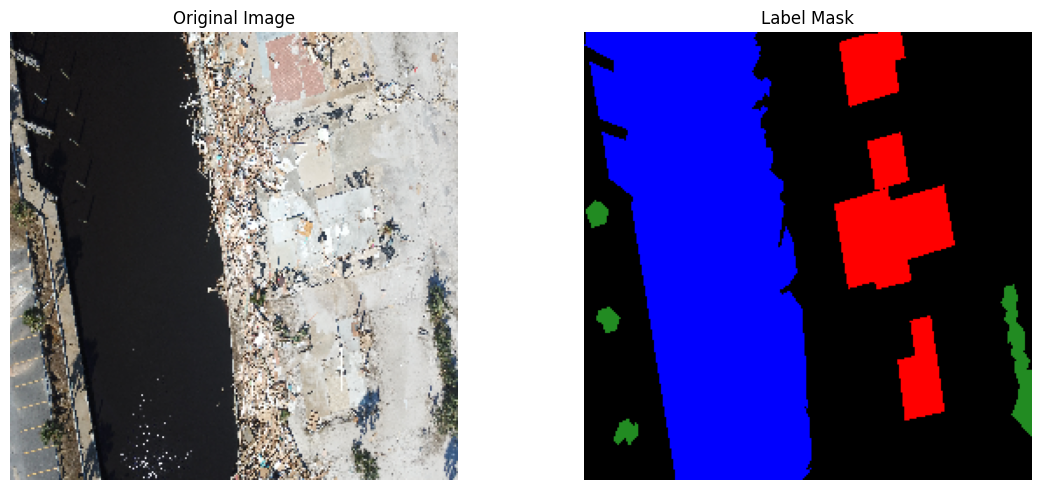

In [49]:
image = images[0]
label = labels[0]

# Convert one-hot encoded labels back to indices
label_indices = np.argmax(label, axis=-1)

# Create RGB image from label indices using the color mapping
height, width = label_indices.shape
label_rgb = np.zeros((height, width, 3), dtype=np.uint8)

# Map each index to its corresponding color
for idx, color in enumerate(colors):
    mask = (label_indices == idx)
    label_rgb[mask] = color

# Display both images side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Label Mask")
plt.imshow(label_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
np.unique(label_indices)

array([0, 1, 5, 9])

In [53]:
label_indices.shape

(256, 256)

In [55]:

print(len(flow.temp_data_names))

510


In [61]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        
        )
    def forward(self,x):
        return self.conv(x)
    
class encoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.conv = conv_block(in_c,out_c)
        self.pool = nn.MaxPool2d((2,2))
    def forward(self,x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p


class attention_gate(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0],out_c,kernel_size=1,padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1],out_c,kernel_size=1,padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c,out_c,kernel_size=1,padding=0),
            nn.Sigmoid()
        )
    def forward(self,g,s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg+Ws)
        out = self.output(out)
        return out*s
        
class decoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = attention_gate(in_c,out_c)
        self.c1 = conv_block(in_c[0]+out_c,out_c)

    def forward(self,x,s):
        x = self.up(x)
        s = self.ag(x,s)
        x = torch.cat([x,s],axis=1)
        x = self.c1(x)
        return x


class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(3,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)

        self.b1 = conv_block(256,512)
        self.d1 = decoder_block([512,256],256)
        self.d2 = decoder_block([256,128],128)
        self.d3 = decoder_block([128,64],64)
        self.output = nn.Conv2d(64,11,kernel_size=1,padding=0)
    def forward(self,x):
        s1,p1 = self.e1(x)
        s2,p2 = self.e2(p1)
        s3,p3 = self.e3(p2)

        b1 = self.b1(p3)
        #print(b1.shape,s3.shape)
        d1 = self.d1(b1,s3)
        d2 = self.d2(d1,s2)
        d3 = self.d3(d2,s1)
        output = self.output(d3)
        return output
        
x = torch.randn((10,3,256,256))
model = attention_unet()
y = model(x)
print(y.shape)

torch.Size([10, 11, 256, 256])


In [63]:
train_flow = AugDirectoryFlow(dataset_directory_train+'train-org-img',\
                              dataset_directory_train+'train-label-img',\
                              batch_size, img_size, h_flip=True, v_flip=True,\
                              zoom_in_scale=1.3) #rotation_deg=90,
val_flow = DirectoryFlow(dataset_directory_val+'val-org-img',\
                         dataset_directory_val+'val-label-img',\
                         batch_size, img_size)

In [67]:
import tensorflow as tf
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [69]:
def pixel_accuracy(preds, labels):
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

In [71]:
def recall_score(preds, labels, target_class=1):
    # Flatten to compare pixel by pixel
    preds = preds.view(-1)
    labels = labels.view(-1)

    tp = ((preds == target_class) & (labels == target_class)).sum().float()
    fn = ((preds != target_class) & (labels == target_class)).sum().float()

    recall = tp / (tp + fn + 1e-8)
    return recall.item()

In [74]:
skip_conn_data = np.array([{}])

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize your model
model = attention_unet().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 2

Using device: cpu


In [78]:
def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Transpose and convert to tensor
        images = np.transpose(images, (0, 3, 1, 2))  # [B, C, H, W]
        images = torch.tensor(images, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)
        labels = torch.argmax(labels, dim=-1)  # Convert from one-hot encoding to class indices


        # Forward pass
        outputs = model(images)
        
        # Convert labels to the right shape
        labels = labels.squeeze(1)
        
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def validate(model, val_loader, loss_fn):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # Transpose and convert to tensor
            images = np.transpose(images, (0, 3, 1, 2))
            images = torch.tensor(images, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            outputs = model(images)
            labels = labels.squeeze(1)
            
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(val_loader)

In [82]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_flow, optimizer, loss_fn)
    val_loss = validate(model, val_flow, loss_fn)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

KeyboardInterrupt: 

In [41]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img', dataset_directory_test+'test-label-img', 2, img_size)
(image, label) = test_flow._get_image_batch()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


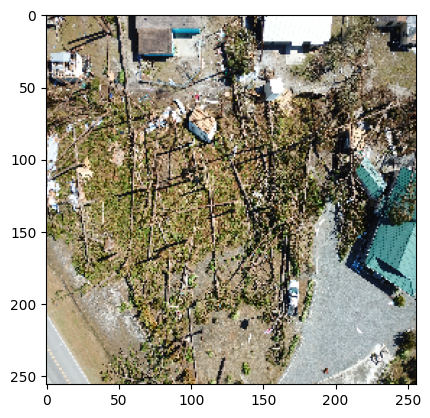

In [43]:
predicted_map = model.predict(image)
#orig picture
plt.imshow(image[0])

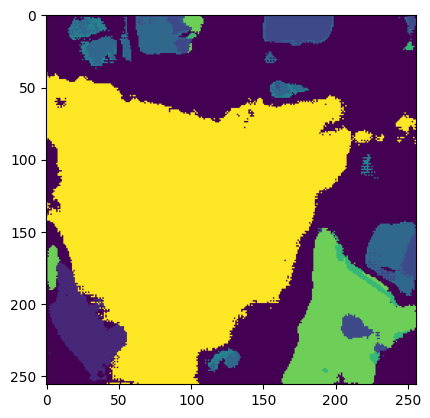

In [45]:
predicted_map_val = tf.argmax(predicted_map[0], axis=-1)
plt.imshow(predicted_map_val)

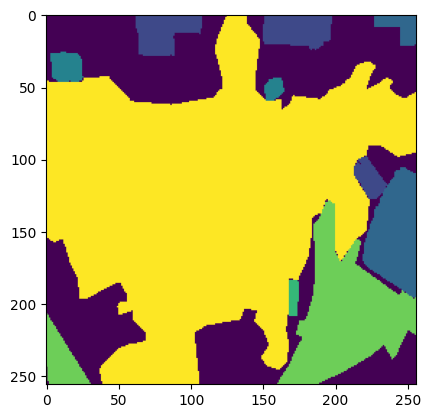

In [47]:
#ground truth
label_val = tf.argmax(label[0], axis=-1)
plt.imshow(label_val)

In [49]:
np.unique(predicted_map_val)

array([0, 1, 2, 3, 4, 6, 7, 9])

In [51]:
np.unique(label_val)

array([0, 2, 3, 4, 6, 7, 9])

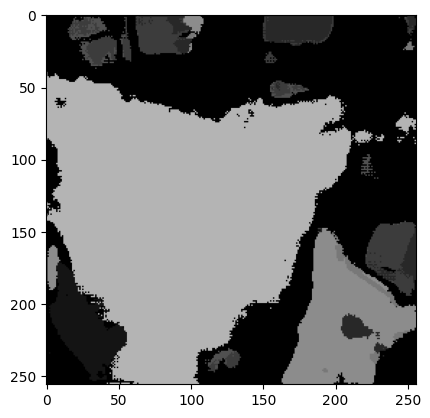

In [53]:
plt.imshow(class_code_to_rgb(predicted_map_val))

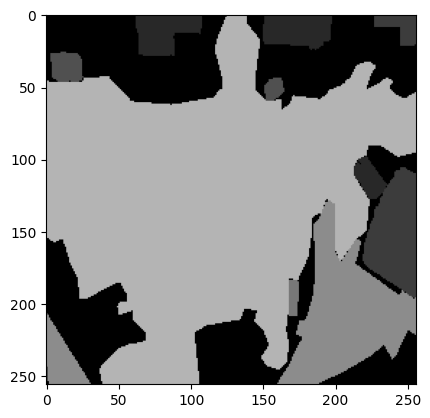

In [55]:
plt.imshow(class_code_to_rgb(label_val))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


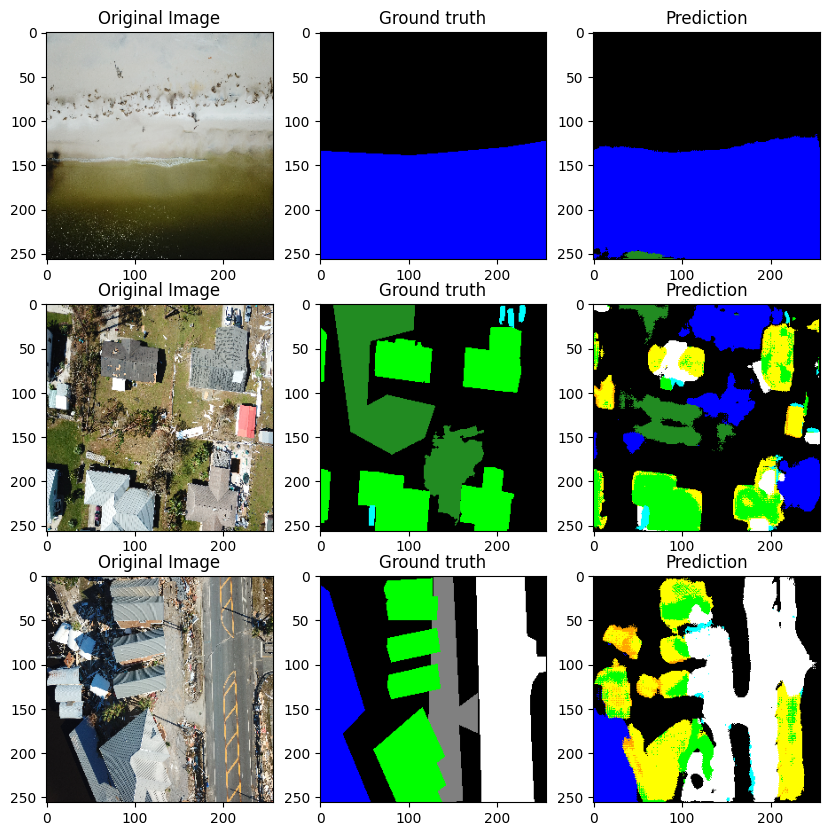

In [61]:
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img',\
                          dataset_directory_test+'test-label-img', 3, img_size)
(image, label) = test_flow._get_image_batch()
predicted_map = model.predict(image)

fig = plt.figure(figsize=(10,10))

for i in range(3):
    fig.add_subplot(3, 3, i*3+1)
    plt.title("Original Image")
    plt.imshow(image[i])
    
    fig.add_subplot(3, 3, i*3+2)
    plt.title("Ground truth")
    plt.imshow(class_code_to_rgb_w_colors(tf.argmax(label[i], axis=-1), colors))
    
    fig.add_subplot(3, 3, i*3+3)
    plt.title("Prediction")
    plt.imshow(class_code_to_rgb_w_colors(tf.argmax(predicted_map[i], axis=-1), colors))
    
plt.show()

In [59]:
class_names_list = list(dataset_classes_names)
num_of_classes = len(dataset_classes_names)
test_flow = DirectoryFlow(dataset_directory_test+'test-org-img',\
                          dataset_directory_test+'test-label-img', batch_size, img_size)

iou_arr = []
for class_num in range(num_of_classes):
    iou_arr.append(tf.keras.metrics.IoU(num_classes=num_of_classes, target_class_ids=[class_num]))



for _ in range(len(test_flow)):
    (images, labels) = test_flow._get_image_batch()
    predictions = model.predict(images, verbose=0)
    for i in range(len(predictions)):
        prediction = tf.argmax(predictions[i], axis=-1)
        label = tf.argmax(labels[i], axis=-1)
        for class_num in range(num_of_classes):
            class_label = label
            class_pred = prediction
            iou_arr[class_num].update_state(class_label, class_pred)
            


for i, iou in enumerate(iou_arr):
    print(f'Class: {class_names_list[i]}, IoU: {iou.result()}')
test_flow.reset_temp_data_names()

Class: unlabelled, IoU: 0.6097083687782288
Class: water, IoU: 0.5634796619415283
Class: building-no-damage, IoU: 0.3286585807800293
Class: building-medium-damage, IoU: 0.18920330703258514
Class: building-major-damage, IoU: 0.038696903735399246
Class: building-total-destruction, IoU: 0.0
Class: vehicle, IoU: 0.12040156126022339
Class: road-clear, IoU: 0.38583725690841675
Class: road-blocked, IoU: 0.0
Class: tree, IoU: 0.6768286824226379
Class: pool, IoU: 0.0
